In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.vae3D import vae_model
from src.classes import Boundary, TankProperties32x2, BallAnomaly
from src.util import load_3Ddata

2025-04-10 09:58:31.883644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744279111.898636 2097742 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744279111.904716 2097742 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 09:58:31.925113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1744279120.040089 2097742 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

**Loading pretrained models**

In [12]:
def mapper(voltage, mapper):
    if mapper == "with_lstm":
        from src.lstm_mapper3D import lstm_mapper3D_model
        lstm_mapper = lstm_mapper3D_model()
        lstm_mapper.summary() 
        lstm_mapper.load_weights("weights/lstm_exp_3D.weights.h5")
        print("Weights of the LSTM mapper loaded successfully.")
        print("Generating latent representations...")
        pred_latent = lstm_mapper.predict(voltage)

    else:
        from src.no_lstm_mapper3D import no_lstm_mapper3D_model
        mapper = no_lstm_mapper3D_model()
        mapper.summary()
        mapper.load_weights("weights/no_lstm_exp_3D.weights.h5")
        print("Weights of the mapper without LSTM loaded successfully.")
        print("Generating latent representations...")
        pred_latent = mapper.predict(voltage)

    return pred_latent

In [3]:
beta =  1.04
vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.build(input_shape=(32, 32, 32, 1))
vae.load_weights("weights/3Dvae.weights.h5")
print("Weights of VAE loaded successfully.")

Weights of VAE loaded successfully.


**Loading test sim data**

In [5]:
voltage_t, gamma_true, pos, temp, time  = load_3Ddata("exp_data_3D","exp_data_set", use_mean= True)

#selection of data:
##########################################################
# exp_data_3D/exp_data_set - big helix, 11,200 samples with 20 rotations
# exp_data_3D/exp_data_set_1 - small helix, 8,000 samples with 20 rotations
# exp_data_3D/exp_data_set_2 - fast helix, 1,400 samples with 20 rotations
# exp_data_3D/exp_data_set_3 - circular sine wave, 3,000 samples 


#Anomalie 0.2 Testdata:
#####################################################################
# exp_data_set_3D/exp_data_3D18 - Helix, 0.7, 11200, n = 20
# exp_data_set_3D/exp_data_3D16 - Helix, 0.5, 8000, n = 20
# exp_data_set_3D/exp_data_3D23 - Helix, 0.6, 9600, n = 20
# exp_data_set_3D_1/exp_data_3D1 - Helix, 0.7, 1400, n = 20 (achtfache Geschwindigkeit)
# exp_data_set_3D_1/exp_data_3D6 - Circularsinwave, 0.7, 3000 
#####################################################################


Loading experimental data...
Calculating mean of voltage differences...
Transforming position data...
Creating gamma...
Processing sequences with mean...
Data loading complete!


**Reconstruction using voltage data**

In [13]:
pred_latent = mapper(voltage_t, "with_lstm") # "with_lstm" or "no_lstm"

Model: "3D_lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4, 64, 64, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 31, 31, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 4, 15, 15, 2)   │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 4, 450)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 4, 64)          │        28,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,610 (174.26 KB)

 Trainable params: 44,610 (174.26 KB)

 Non-trainable params: 0 (0.00 B)

Weights of the LSTM mapper loaded successfully.
Generating latent representations...
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [14]:
model_variant='3D_lstm_small_helix'
gamma_true_pred = vae.decoder.predict(pred_latent)

350/350 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step


In [15]:
gamma_true_pred = np.squeeze(gamma_true_pred, axis=-1)
gamma_true_pred = np.clip(gamma_true_pred, a_min =0, a_max=1)

/home/jy2353/LSTM EIT Repo/Dynamic-object-trajectory-prediction-of-time-dependent-EIT-data-using-recurrent-neural-networks/src/performance_eval.py:505: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(h_pad=-1.5, w_pad=3, rect=[0, 0.05, 1, 1])


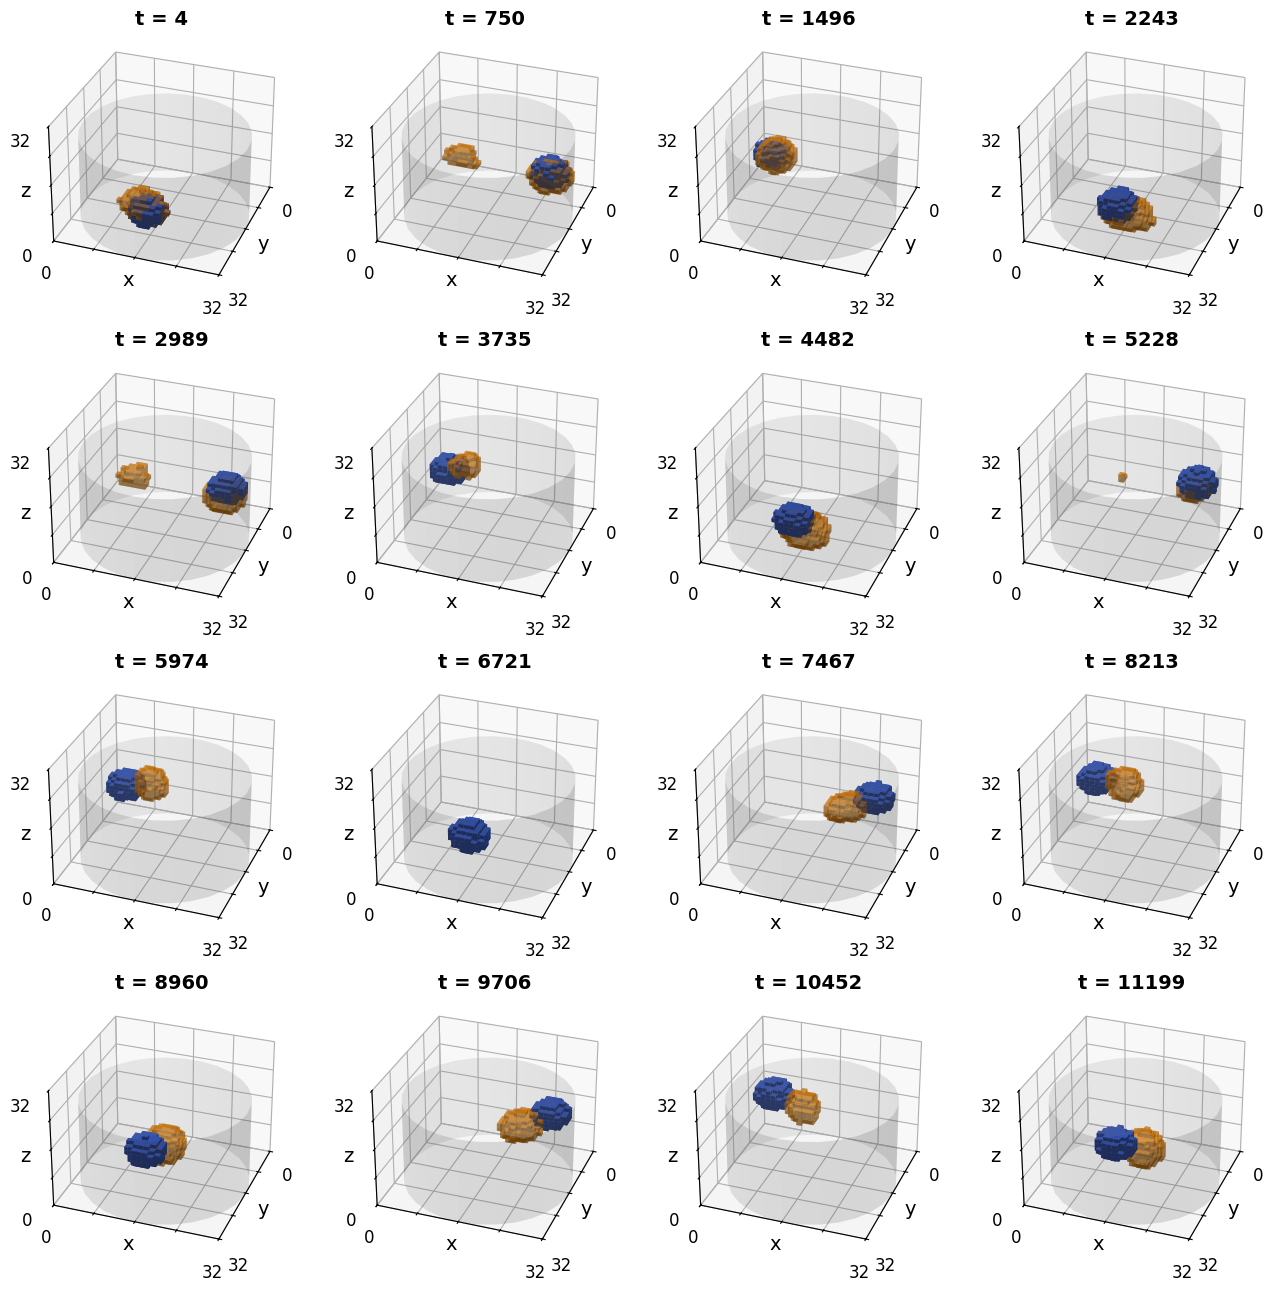

In [17]:
from src.performance_eval import plot_voxel_overlay, plot_position_error, plot_volume_deviations

plot_voxel_overlay(
    gamma_true, 
    gamma_true_pred, 
    pos, 
    save = False, 
    fpath='results/', 
    fname=f'seq_recon_overlay_{model_variant}'
)

Anzahl der ignorierten Matrizen: 29
Anzahl der berücksichtigten Paare: 2967


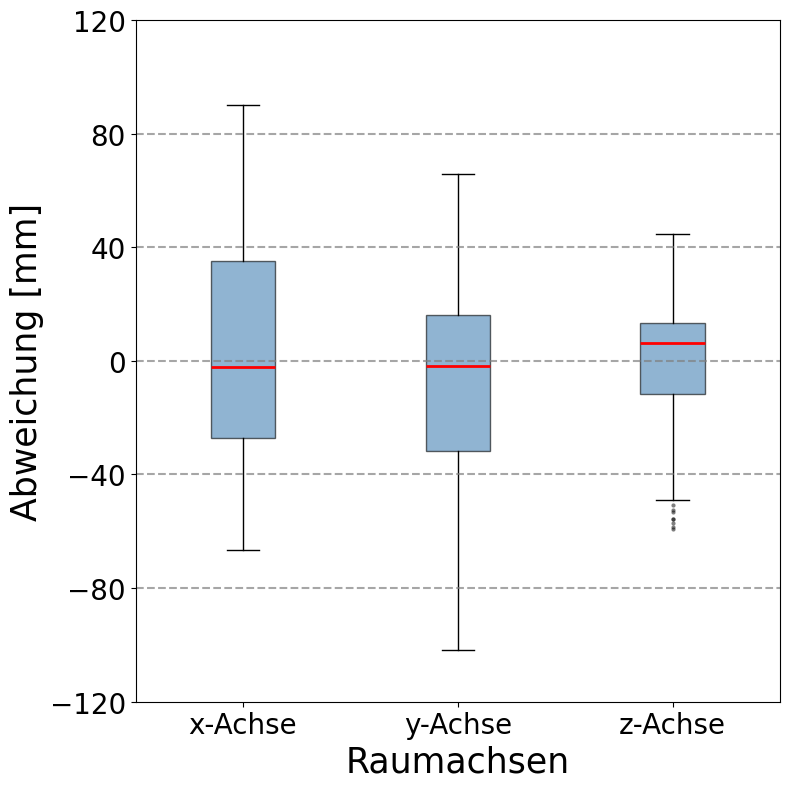


Statistische Kennzahlen:
     Achse   Mittelwert   Std.Abw.     Median        IQR
------------------------------------------------------------
   x-Achse        4.742     39.840     -2.230     62.571
   y-Achse       -7.273     38.160     -1.715     47.940
   z-Achse        0.486     18.490      6.119     24.969

Ausreißer nach 1.5 IQR Regel:
     Achse     Anzahl    Prozent
-----------------------------------
   x-Achse          0      0.00%
   y-Achse          0      0.00%
   z-Achse          8      0.27%


In [9]:
plot_position_error(
    gamma_true_pred, 
    gamma_true,  
    fpath='results/',
    fname=f'seq_recon_{model_variant}', 
    save = False
)

PDF saved to: Abbildung_3D/seq_recon_3D_lstm_small_helix_volume_deviations.pdf
Statistics saved to: Abbildung_3D/seq_recon_3D_lstm_small_helix_volume_deviations_stats.txt


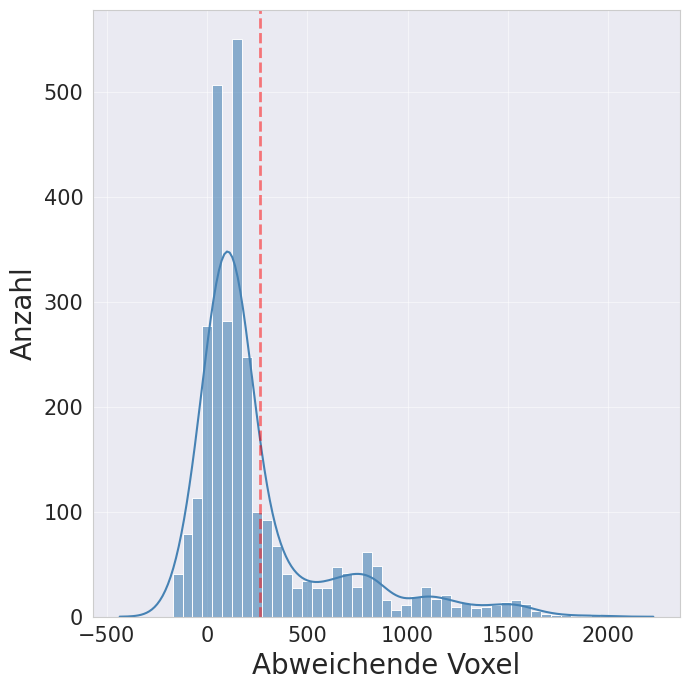

Mittlere Volumenabweichung: 262 Voxel
Standardabweichung: 362.2 Voxel


In [10]:
plot_volume_deviations(
    gamma_true_pred, 
    gamma_true, 
    fpath='results/', 
    fname=f'seq_recon_{model_variant}', 
    save = True
)